# Sprawozdanie z projektu - sieci neuronowe
### Temat: Analiza histopatologiczna
### Skład grupy: Aleksandra Kostkiewicz, Sandra Stelmachowicz, Daria Pawlak

### Na czym polega nasze zadanie? 

Naszym zadaniem jest stworzenie takiego modelu, który na podstawie skanów histopatlogicznych odcinków węzłów chłonnych wykrywa obecność lub brak tkanek nowotworowych. Korzystamy z mniejszych fragmentów obrazów pobranych z większych cyfrowych skanów patologicznych.


### Nasze dane 
W pierwszej części naszego projektu zajęłyśmy się przygotowaniem naszych obrazków, aby móc na nich pracować.
Dane posiadamy z platformy Kaggle,które są zmodyfikowaną wersją PatchCamelyon. Zbiór ten nie posiada już dublikatów.


Poniżej pokażemy przykładowe obrazki, z których  nasz model będzie korzystać. Etykieta "0" oznacza, że nie występuję tkanka nowotworowa, a przy etykiecie "1" występuje.

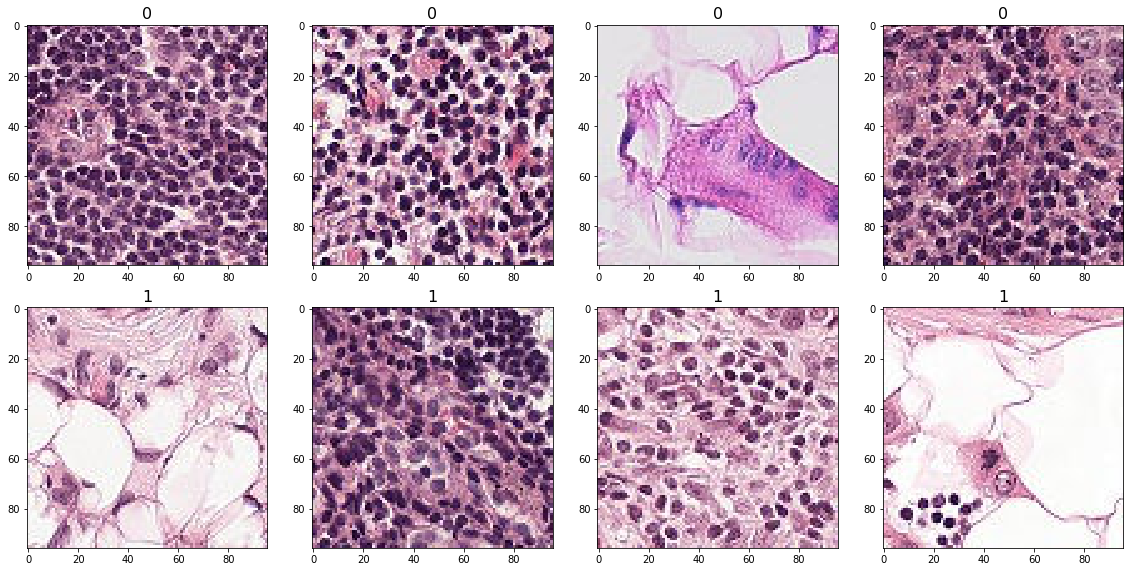

In [ ]:
from IPython.display import Image
Image(filename="../input/imagea/ma.png")

In [ ]:
import pandas as pd
import numpy as np

import imageio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 2000

**Srawdzamy jakie pliki są dostępne i czy są wszystkie, które są nam potrzebne.**

In [ ]:
os.listdir('../input/histopathologic-cancer-detection/')

**Sprawdzamy ile obrazków mamy w każdym folderze.**

In [ ]:
print("Folder treningowy wynosi {} obrazów".format(len(os.listdir('../input/histopathologic-cancer-detection/train'))))
print("Folder testowy wynosi {} obrazów".format(len(os.listdir('../input/histopathologic-cancer-detection/test'))))

Wynikiem powyższego kodu jest:

* Folder treningowy wynosi 220025 obrazów

* Folder testowy wynosi 57458 obrazów

**Tworzymy ramkę danych zawierającą wszystkie obrazki.**

In [ ]:
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print("Rozmiar zbioru danych wynosi {} wierszy i".format(df_data.shape[0])," {} kolumny.".format(df_data.shape[1]))

Wynikiem powyższego kodu jest:
* Rozmiar zbioru danych wynosi 220025 wierszy i  2 kolumny.

**Sprawdzamy jakie klasy mamy.**

Klasa 0 - nie ma komórek nowotworowych

Klasa 1 - ma komórki nowotworowe

In [ ]:
df_data['label'].value_counts()

**Pokazanie losowych przykładów z obrazków treningowych z podziałem na klasy.**

In [ ]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, figsize=(4*figure_cols,4*len(categories)))
    
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) 
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

In [ ]:
IMAGE_PATH = '../input/histopathologic-cancer-detection/train/'

In [ ]:
draw_category_images('label', 4, df_data, IMAGE_PATH)

**Tworzenie treningowych zestawów i zestawów poprawności.**

In [ ]:
df_data.head()

**Zbalansowanie rozkładu docelowego.**

Zmniejszenie ilości przykładów w klasie 0 i 1.

In [ ]:
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)

df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

df_data = pd.concat([df_0, df_1],axis = 0).reset_index(drop = True)

df_data = shuffle(df_data)

df_data['label'].value_counts()

In [ ]:
df_data.head()

**Tworzenie zbilansowanego zestawu walidacyjnego.**

In [ ]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size = 0.20, random_state = 101, stratify = y)

print("W zbilansowanym zestawie treningowym mamy {} wierszy i ".format(df_train.shape[0])," {} kolumn.".format(df_train.shape[1]))
print("W zbilansowanym zestawie poprawności mamy {} wierszy i ".format(df_val.shape[0])," {} kolumn.".format(df_val.shape[1]))

In [ ]:
df_train['label'].value_counts()

In [ ]:
df_val['label'].value_counts()

**Tworzenie struktury katalogów.**

Najpierw tworzymy główny katalog o nazwie base_dir, w kótrym będą 2 foldery: train_dir i val_dir. W każdym z tych dwóch folderów tworzymy dwa następne, które będą dzielić dane na zawierające komórki nowotworowe i niezawierające.

In [ ]:
base_dir = 'base_dir'
os.mkdir(base_dir)

In [ ]:
train_dir = os.path.join(base_dir,'train_dir')
os.mkdir(train_dir)

In [ ]:
val_dir = os.path.join(base_dir,'val_dir')
os.mkdir(val_dir)

In [ ]:
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)

In [ ]:
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [ ]:
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)

In [ ]:
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

**Sprawdzamy czy foldery na pewno powstały.**

In [ ]:
os.listdir('base_dir/train_dir')

In [ ]:
os.listdir('base_dir/val_dir')

**Przenosimy obrazki do folderów.**

In [ ]:
df_data.set_index('id', inplace=True)

In [ ]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

In [ ]:
for image in train_list:
    # 'id' w pliku csv nie ma rozszerzenia .tif dlatego je teraz dodajemy
    fname = image + '.tif'
    
    #dodawanie etykiety do obecnego obrazka
    target = df_data.loc[image,'label']
    
    #wybieramy odpowiednią nazwę folderu, ze względu na klasę
    if target == 0:
        label = 'a_no_tumor_tissue'
    
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    #ścieżka źródłowa do obrazka
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    
    #miejsce docelowe dla obrazka
    dst = os.path.join(train_dir, label, fname)
    
    #kopiowanie obrazka ze źródła do pliku docelowego
    shutil.copyfile(src, dst)
    
for image in val_list:
    fname = image + '.tif'
    
    target = df_data.loc[image,'label']
    
    if target == 0:
        label = 'a_no_tumor_tissue'
    
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    
    
    dst = os.path.join(val_dir, label, fname)
    
    shutil.copyfile(src, dst)

**Sprawdzamy ile mamy treningowych obrazków w każdym folderze.**

In [ ]:
print("W folderze treningowym mamy {} obrazów, gdzie nie ma komórek nowotworowych.".format(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue'))))
print("W folderze treningowym mamy {} obrazów, na których są komórki nowotworowe.".format(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue'))))

In [ ]:
print("W folderze walidacyjnym mamy {} obrazów, na których  nie ma komórek nowotworowych.".format(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue'))))
print("W folderze walidacyjnym mamy {} obrazów, gdzie są komórki nowotworowe.".format(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue'))))

**Ustalenie generatorów**

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

**Poniżej przeskalowujemy wszystkie obrazy o współczynnik 1/255, czyli wartości pikseli do zakresu [0,1], ponieważ sieci neuronowe lepiej sobie radzą z małymi wartościami wejściowymi**

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

 **Tworzenie architektury modeli**

## Architektura modeli
Wykorzystamy konwulucyjne sieci neuronowe(CNN). W naszym wypadku mając dane wejściowe (skany histopatologiczne), po wrzuceniu ich do naszej sieci neuronowej chcemy uzyskać etykietę 0 lub 1, w zależności od występowania tkanki nowotworowej.
Do budowy modeli, wykorzystamy z biblioteki Keras klasę Sequential, która umożliwia definiowanie kolejnych wartstw, niczym układanie na stosie.
Wykorzystamy następujące warstwy:
* MaxPooling2D jest operacją skalowania. Polega na redukcji wymiarowości przechodząc po obrazie "okienkami", które zwracają maksymalną zaobserwowaną wartość w danym oknie ( w naszym wypadku rozmiar okna 2x2, przy kroku przesunięcia równym 2). Pomaga to zmniejszyć rozmiar danych wejściowych do kolejnej warstwy o połowę, co przyśpiesza proces uczenia.
* Conv2d jest warstwą konwolucji, w której musimy podać minimum trzy parametry: 
  1. liczbe filtrów, dzięki którym będą wydobywane cechy
  2. rozmiar jądra czyli w naszym wypadku wielkość okna konwolucji zakładamy że ma 3x3
  3. funkcje aktywacji 
* Flatten wypłaszcza nam nasze dane w celu polączenia ich warstwami gęstymi pod koniec budowy modelu.
* Dense - warstwy gęste z czego ostatnia warstwa gęsta ma Softmax. Jest to w istocie funkcja wykładnicza, której wartość zostaje jednak dodatkowo znormalizowana w taki sposób, aby suma aktywacji dla całej warstwy była równa 1.

In [ ]:
kernel_size = (3,3)
pool_size = (2,2)
first_filters = 64
second_filters = 128
third_filters = 256

In [ ]:
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Flatten())
model.add(Dense(256, activation = "relu"))

model.add(Dense(2, activation = "softmax"))

model.summary()

In [ ]:
model.compile(Adam(0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(val_gen.class_indices)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, restore_best_weights = True)
reduce_l = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1)

In [ ]:
history = model.fit_generator(train_gen, steps_per_epoch = train_steps, 
                              validation_data = val_gen, 
                              validation_steps = val_steps,
                              epochs = 10, 
                              callbacks = [reduce_l])

Epoch 1/10
320/320 [==============================] - 285s 891ms/step - loss: 7.6214 - accuracy: 0.5019 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 2/10
320/320 [==============================] - 285s 892ms/step - loss: 7.7340 - accuracy: 0.4972 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 3/10
320/320 [==============================] - 287s 896ms/step - loss: 7.8421 - accuracy: 0.4900 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 4/10
320/320 [==============================] - 287s 896ms/step - loss: 7.5454 - accuracy: 0.5094 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 5/10
320/320 [==============================] - 286s 893ms/step - loss: 7.7628 - accuracy: 0.4953 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 6/10
320/320 [==============================] - 291s 910ms/step - loss: 7.6811 - accuracy: 0.5006 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 7/10
320/320 [==============================] - 286s 894ms/step - loss: 7.6944 - accuracy: 0.4997 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 8/10
320/320 [==============================] - 286s 893ms/step - loss: 7.6319 - accuracy: 0.5038 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 9/10
320/320 [==============================] - 286s 893ms/step - loss: 7.6847 - accuracy: 0.5003 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 10/10
320/320 [==============================] - 287s 897ms/step - loss: 7.6920 - accuracy: 0.4997 - val_loss: 7.4396 - val_accuracy: 0.5163

**Plot the Training Curves**

In [ ]:
val_loss, val_acc = \
model.evaluate_generator(test_gen, steps = len(df_val))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

In [ ]:
print('val_loss:', val_loss)
print('val_acc:', val_acc)

In [ ]:
plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

In [ ]:
from IPython.display import Image
Image(filename="../input/imagea/loss.png")

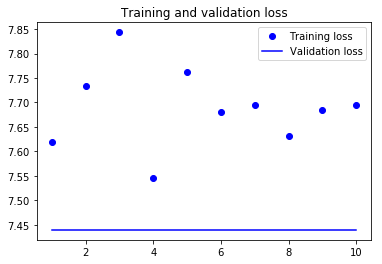

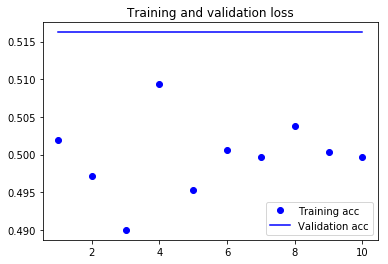

In [ ]:
from IPython.display import Image
Image(filename="../input/imagea/acc.png")

**Drugi model**

In [ ]:
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 


model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))


model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))

model.add(Dense(2, activation = "softmax"))

model.summary()

In [ ]:
model.compile(Adam(0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(val_gen.class_indices)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, restore_best_weights = True)
reduce_l = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1)

In [ ]:
hist = model.fit_generator(train_gen, steps_per_epoch = train_steps, 
                              validation_data = val_gen, 
                              validation_steps = val_steps,
                              epochs = 10, 
                              callbacks = [reduce_l])

Epoch 1/10
320/320 [==============================] - 491s 2s/step - loss: 7.6653 - accuracy: 0.4994 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 2/10
320/320 [==============================] - 487s 2s/step - loss: 7.7136 - accuracy: 0.4984 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 3/10
320/320 [==============================] - 494s 2s/step - loss: 7.6727 - accuracy: 0.5009 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 4/10
320/320 [==============================] - 488s 2s/step - loss: 7.6920 - accuracy: 0.4997 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 5/10
320/320 [==============================] - 486s 2s/step - loss: 7.6775 - accuracy: 0.5009 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 6/10
320/320 [==============================] - 486s 2s/step - loss: 7.7088 - accuracy: 0.4988 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 7/10
320/320 [==============================] - 487s 2s/step - loss: 7.6763 - accuracy: 0.5009 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 8/10
320/320 [==============================] - 488s 2s/step - loss: 7.6138 - accuracy: 0.5050 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 9/10
320/320 [==============================] - 487s 2s/step - loss: 7.8241 - accuracy: 0.4912 - val_loss: 7.9395 - val_accuracy: 0.4837


Epoch 10/10
320/320 [==============================] - 485s 2s/step - loss: 7.6571 - accuracy: 0.5019 - val_loss: 7.9395 - val_accuracy: 0.4837

**Plot the Training Curves**

In [ ]:
val_loss, val_acc = \
model.evaluate_generator(test_gen, steps = len(df_val))

In [ ]:
print('val_loss:', val_loss)
print('val_acc:', val_acc)

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,len(acc)+1)

In [ ]:
plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

In [ ]:
from IPython.display import Image
Image(filename="../input/imagea/loss1.png")

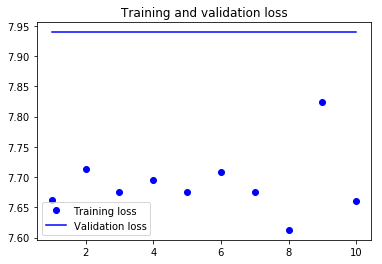

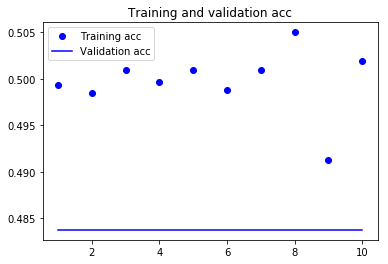

In [ ]:
from IPython.display import Image
Image(filename="../input/imagea/acc1.png")

**Trzeci model z Dropout**

In [ ]:
kernel_size = (3,3)
pool_size = (2,2)
first_filters = 64
second_filters = 128
third_filters = 256

In [ ]:
dropout_conv = 0.3
dropout_dense = 0.3

In [ ]:
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

In [ ]:
model.compile(Adam(0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
print(val_gen.class_indices)

In [ ]:
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, restore_best_weights = True)
reduce_l = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1)

In [ ]:
hist = model.fit_generator(train_gen, steps_per_epoch = train_steps, 
                              validation_data = val_gen, 
                              validation_steps = val_steps,
                              epochs = 10, 
                              callbacks = [reduce_l])

Epoch 1/10
320/320 [==============================] - 491s 2s/step - loss: 7.6953 - accuracy: 0.4987 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 2/10
320/320 [==============================] - 492s 2s/step - loss: 7.7436 - accuracy: 0.4966 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 3/10
320/320 [==============================] - 481s 2s/step - loss: 7.6367 - accuracy: 0.5034 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 4/10
320/320 [==============================] - 491s 2s/step - loss: 7.7472 - accuracy: 0.4962 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 5/10
320/320 [==============================] - 491s 2s/step - loss: 7.6018 - accuracy: 0.5056 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 6/10
320/320 [==============================] - 493s 2s/step - loss: 7.6547 - accuracy: 0.5022 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 7/10
320/320 [==============================] - 489s 2s/step - loss: 7.7340 - accuracy: 0.4969 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 8/10
320/320 [==============================] - 481s 2s/step - loss: 7.5634 - accuracy: 0.5081 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 9/10
320/320 [==============================] - 489s 2s/step - loss: 7.7761 - accuracy: 0.4944 - val_loss: 7.4396 - val_accuracy: 0.5163


Epoch 10/10
320/320 [==============================] - 491s 2s/step - loss: 7.7448 - accuracy: 0.4966 - val_loss: 7.4396 - val_accuracy: 0.5163

In [ ]:
val_loss, val_acc = \
model.evaluate_generator(test_gen, steps = len(df_val))

**Plot the Training Curves**

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,len(acc)+1)

In [ ]:
plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

In [ ]:
from IPython.display import Image
Image(filename="../input/imagea/loss2.png")

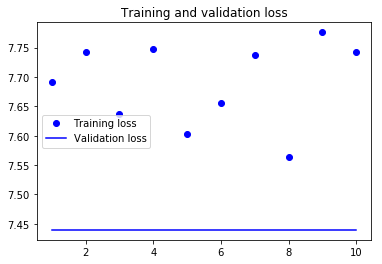

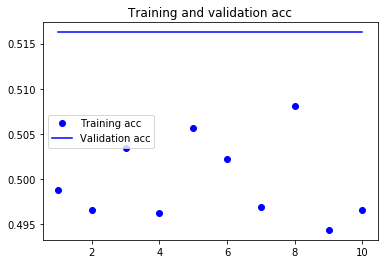

In [ ]:
from IPython.display import Image
Image(filename="../input/imagea/acc2.png")